In [1]:
import scipy 
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_sequence = 100
sequence_length = 1000
generator = np.random.default_rng(seed=0)

(array([ 2.,  0., 12., 14., 14., 17., 16.,  8.,  9.,  8.]),
 array([-1.16251539, -0.94614422, -0.72977305, -0.51340188, -0.29703072,
        -0.08065955,  0.13571162,  0.35208279,  0.56845396,  0.78482512,
         1.00119629]),
 <BarContainer object of 10 artists>)

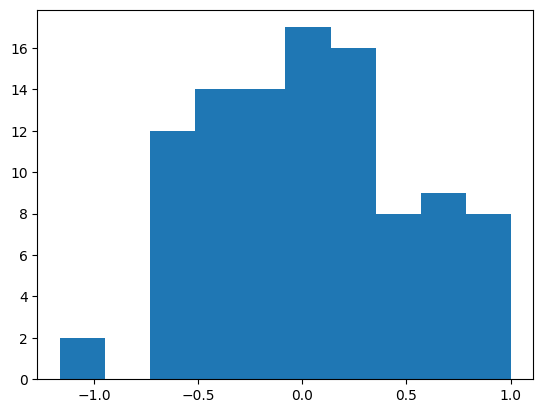

In [3]:
plt.hist(generator.normal(0, 0.5, 100))

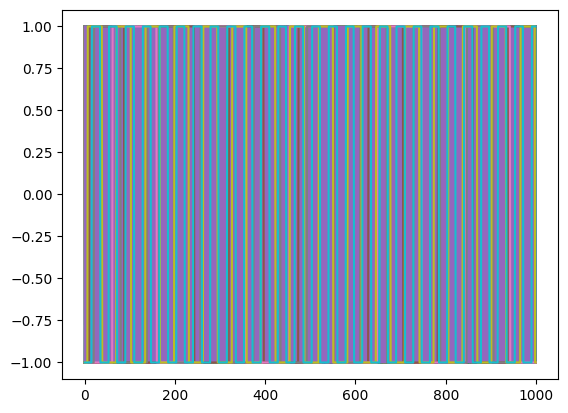

In [4]:
period = np.full(n_sequence, sequence_length/10)
period += 2*(generator.random(n_sequence)-0.5)*period

phase = generator.random(n_sequence)*period
t = np.linspace(phase, sequence_length+phase, sequence_length, endpoint=False).T
control = signal.square(2 * np.pi *((1/period)*t.T).T)

for i in range(n_sequence):
    plt.plot(np.linspace(0, sequence_length, sequence_length, endpoint=False), control[i])

(array([11.,  8.,  9.,  9.,  7., 15.,  5.,  8., 14., 14.]),
 array([  1.28177653,  21.05194584,  40.82211515,  60.59228446,
         80.36245377, 100.13262308, 119.90279239, 139.6729617 ,
        159.44313101, 179.21330032, 198.98346963]),
 <BarContainer object of 10 artists>)

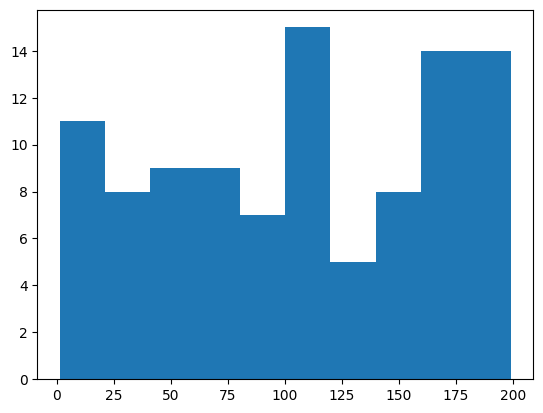

In [5]:
plt.hist(period)

In [ ]:
from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base

from hamilton import driver
import torch


d = driver.Builder().with_modules(base, shared).build()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

inputs = {"sequence_lenght": 1000,
        "n_sequence": 10000,
        "context_size": 200,
        "state_control":"periodic",
        "seed":0
                       }

In [ ]:
outputs = d.execute(["toy1d_data"], inputs=inputs)

In [9]:
outputs["toy1d_data"]["state_decoded"].shape

(10000, 1000, 3)

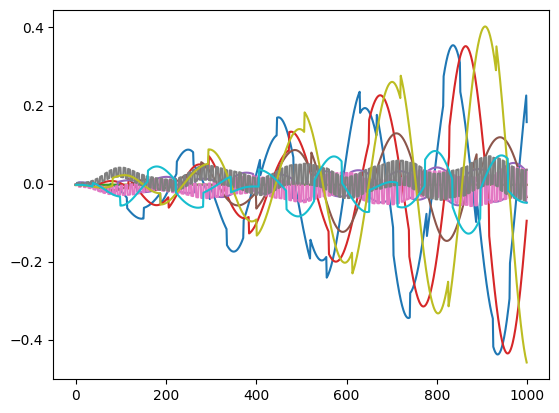

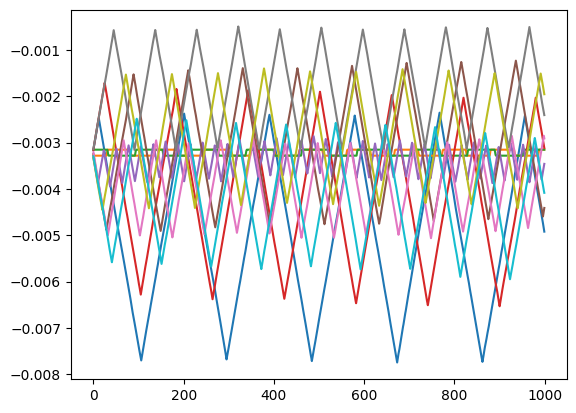

In [10]:
for i in range(10):
    plt.plot(outputs["toy1d_data"]["state_decoded"][i,:,0])
plt.show()



for i in range(10):
    plt.plot(outputs["toy1d_data"]["state_decoded"][i,:,2])
plt.show()


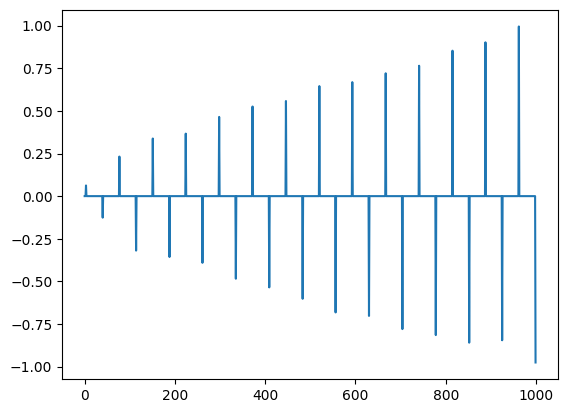

In [11]:
plt.plot(outputs["toy1d_data"]["state_control"][0,:,0])

In [12]:
period = np.full(n_sequence, sequence_length/10)
period += 3*(generator.random(n_sequence)-0.5)*period

phase = generator.random(n_sequence)*period
t = np.linspace(phase, sequence_length+phase,
            sequence_length, endpoint=False).T
control_pulse = signal.square(2 * np.pi * ((1/period)*t.T).T)
control_pulse = (control_pulse-np.roll(control_pulse, 1, 1))/2

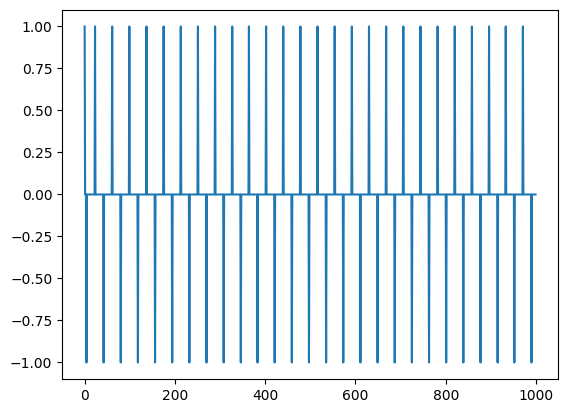

In [13]:
plt.plot(control_pulse[0])

## Eval model

In [49]:
import os

import scipy 
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from hamilton import driver
import torch
from tensordict import TensorDict

from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base


In [23]:
d = driver.Builder().with_modules(base, shared).build()

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [25]:


inputs = {"sequence_lenght": 1000,
            "n_sequence": 10000,
            "context_size": 200,
            "state_dimensions": None,
            "batch_size": 32,
            "device": device,
            "seed":[0, 42],
            "state_control": "periodic",
        }

In [26]:
outputs = d.execute(["toy1d_data", "toy1d_dataloaders"], inputs=inputs)

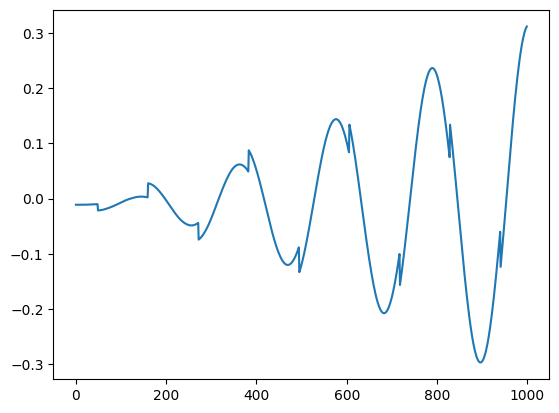

In [27]:
plt.plot(outputs["toy1d_data"]["state_decoded"][3,:,0])

In [28]:
item = next(iter(outputs["toy1d_dataloaders"]["train"]))

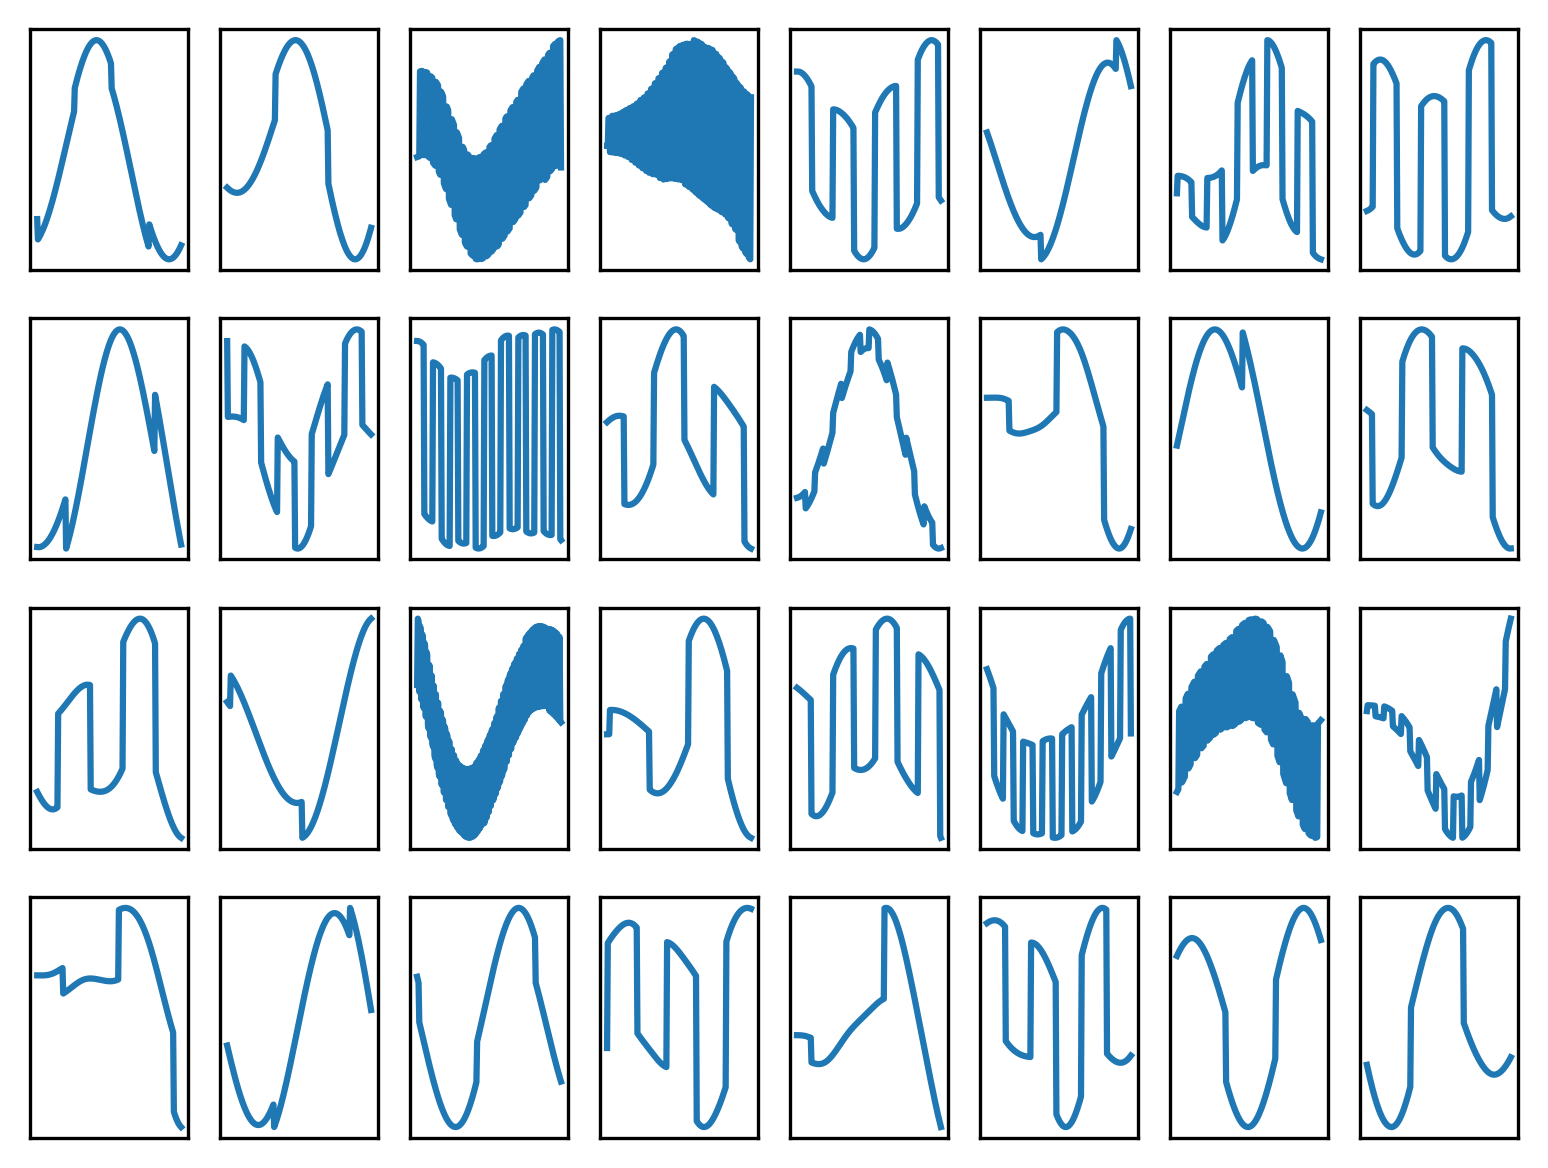

In [29]:
axis = 0
fig, axs = plt.subplots(4, 8, dpi=300)

for i in range(32):
    row = i // 8
    column = i % 8

    axs[row, column].plot(item["targets"]["state_decoded"][i,:,0])


    axs[row, column].set_xticks([])
    axs[row, column].set_yticks([])

plt.show()

In [151]:
names = [
    "Base",
    "M0-90",
    "NoDiscover_M0-90",
    "Break1",
    "Break1_M0-100",
    "Break1_M0-100_FF",
    "Break4_M0-100_FF",
    "2Break1_M0-100_FF",
    "MLP_Break1_M0-100_FF_TRAINM",
    "MLP_Break1_M0-100_FF_TRAINM_SS12",
    "MLP_Break1_M0-100_FF_LTANH",
    "MLP_Break1_M0or100_FF",
    "Break1_M0-100_FF_Alibi"
]

experiment_path = "toy1d_memory"#"toy1d_memory_long"

models = {}
for name in names:
    try:
        models[name] = torch.load(os.path.join(experiment_path, name, "run_0","toy1d_model.pt"))
    except:
        pass



models["NoDiscover_M0-90_NoDecoded"] = models["NoDiscover_M0-90"]


for name in models:
    models[name].eval()
    models[name].to(device)

torch.set_grad_enabled(False)

len(models)-1

C:\Users\eltsu\AppData\Local\Temp\ipykernel_20688\828498546.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models[name] = torch.load(os.path.join(experiment_path, name

13

In [152]:
inputs: torch.Tensor = item["inputs"].to(device)
targets: torch.Tensor = item["targets"]["state_decoded"].to(
    device)

if "state_decoded" in inputs:
    batch_size = inputs["state_decoded"].shape[0]
    seq_len = inputs["state_decoded"].shape[1]

state = {}

for model_name in models:
    state_size = models[model_name]._state_size
    state[model_name] = torch.rand((batch_size, seq_len, state_size), device=device)
    state[model_name] = (2*state[model_name])-1

sensorial_masks = None

for i in range(seq_len):
    logits = {}
    for name in models:
        
        if name == "NoDiscover_M0-90":
            state_decoded = inputs["state_decoded"]
        else:
            state_decoded = None

        logits[name] = models[name](
            state=state[name], 
            state_decoded=state_decoded,
            sensorial_data=inputs, sensorial_masks=sensorial_masks)

        if i != seq_len-1:
            state[name][:, i+1] = logits[name]["state"][:, i]

In [153]:
logits = {name:logits[name].cpu() for name in logits}

In [174]:
seq_to_plot = 2

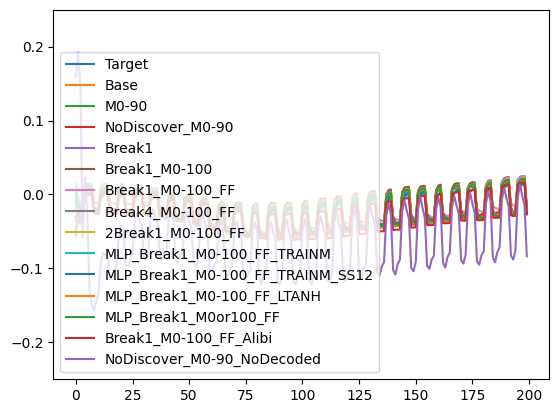

In [175]:
plt.plot(item["targets"]["state_decoded"][seq_to_plot,:,0], label="Target")
for name in logits:
    plt.plot(logits[name]["state_decoded"][seq_to_plot,:,0], label=name)

plt.ylim(-0.25, 0.25)
plt.legend()

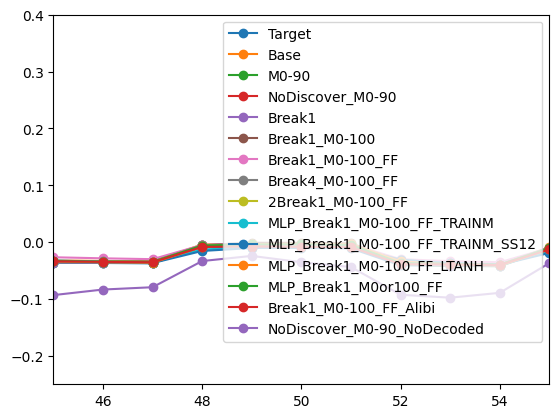

In [ ]:
plt.plot(item["targets"]["state_decoded"][0,:,0], "o-", label="Target")
for name in logits:
    plt.plot(logits[name]["state_decoded"][0,:,0], "o-", label=name)

plt.xlim(45,55)
plt.ylim(-0.25, 0.4)
plt.legend()

(45.0, 55.0)

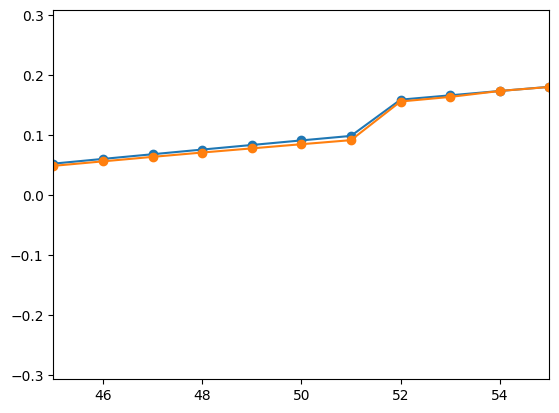

In [156]:
plt.plot(item["targets"]["state_decoded"][0,:,0], "o-")
plt.plot(logits["Base"]["state_decoded"][0,:,0], "o-")

plt.xlim(45,55)

In [157]:
logits["Base"]["state_decoded"][0,:,0][:10], logits["M0-90"]["state_decoded"][0,:,0][:10]

(tensor([-0.1808, -0.2351, -0.2244, -0.2198, -0.2161, -0.2128, -0.2094, -0.2058,
         -0.2021, -0.1981]),
 tensor([-0.1042, -0.1968, -0.2336, -0.2582, -0.2699, -0.2584, -0.2366, -0.2249,
         -0.2181, -0.2115]))

In [158]:
state_half = {name:state[name][:, 100:].clone() for name in state}

sensorial_masks = None

inputs_half = {}

for name in inputs.keys():
    inputs_half[name] = inputs[name][:, 100:].clone()

inputs_half = TensorDict(inputs_half)

for i in range(100):
    logits_half = {}
    for name in models:
        if name == "NoDiscover_M0-90":
            state_decoded = inputs["state_decoded"]
        else:
            state_decoded = None

        logits_half[name] = models[name](
            state=state_half[name],
            state_decoded=state_decoded,
            sensorial_data=inputs_half, sensorial_masks=sensorial_masks, input_sequence_size=100)

        if i != 100-1:
            state_half[name][:, i+1] = logits_half[name]["state"][:, i]

logits_half = {name:logits_half[name].cpu() for name in logits_half}

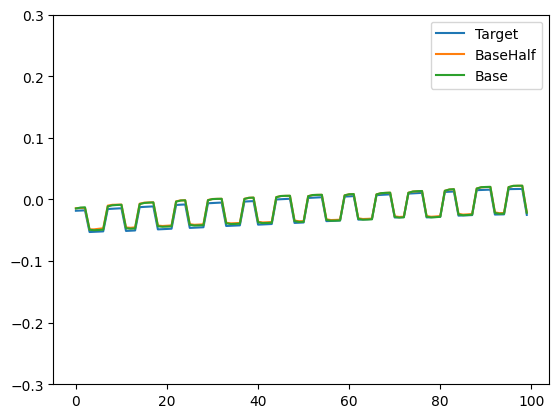

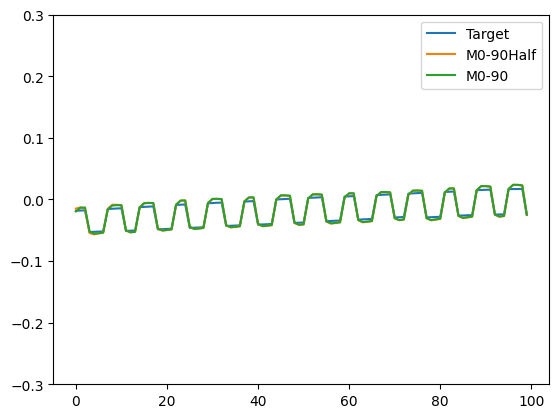

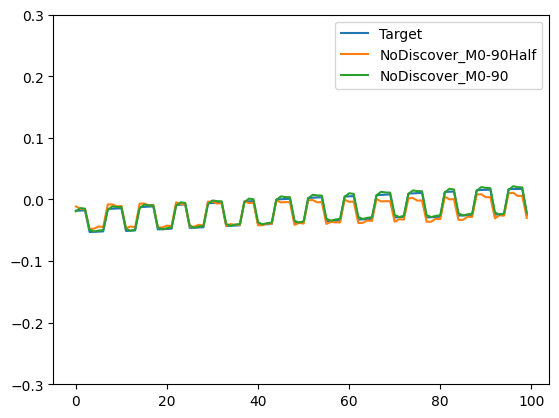

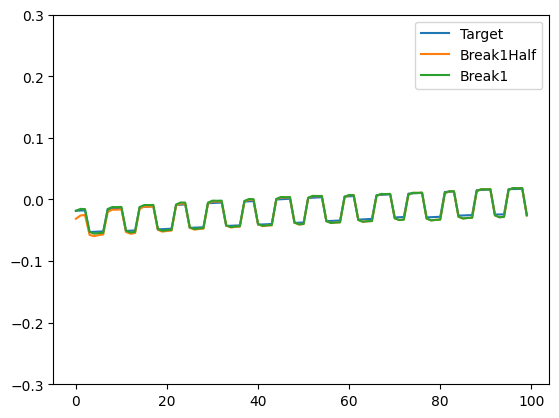

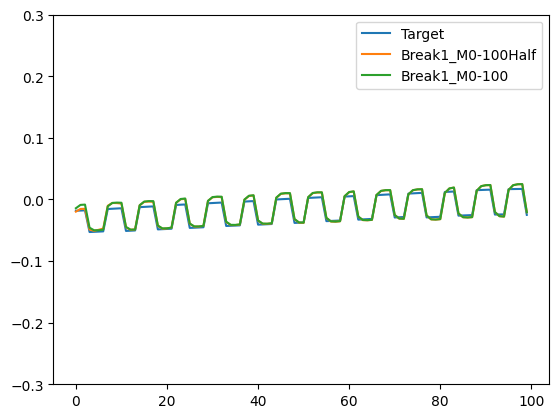

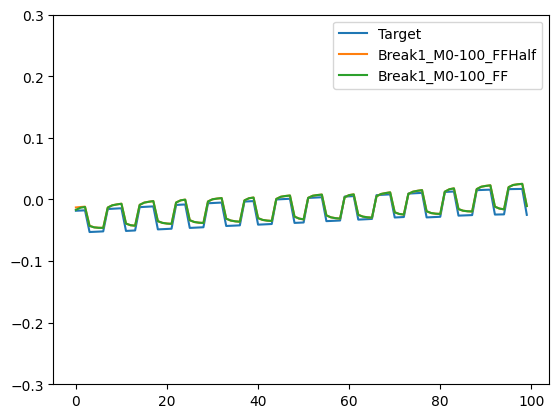

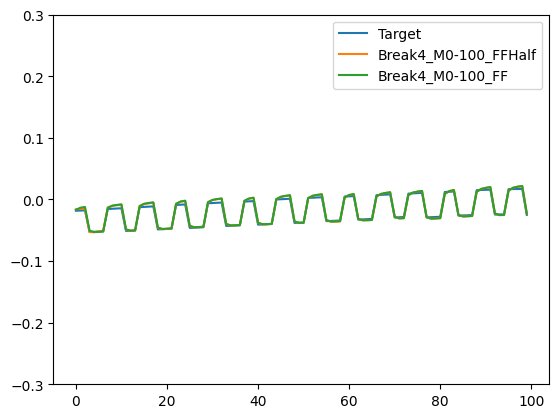

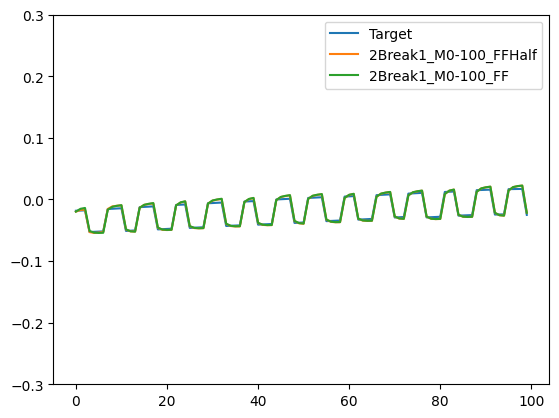

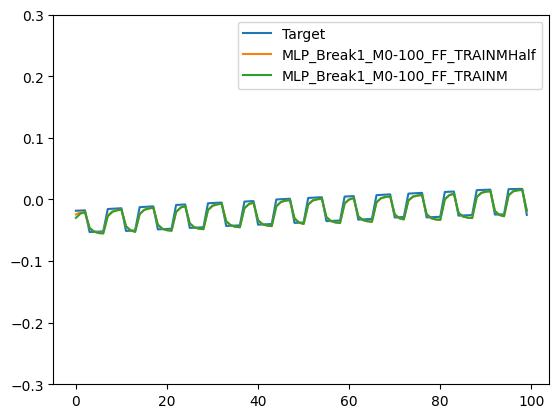

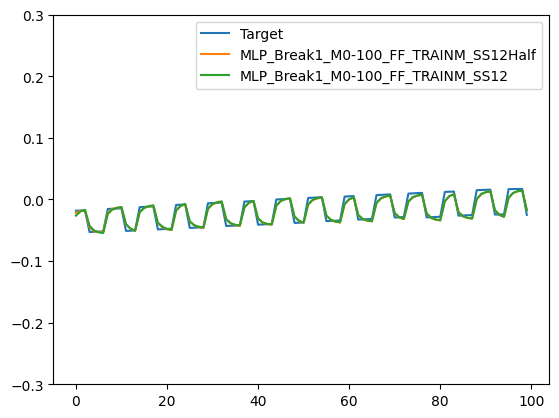

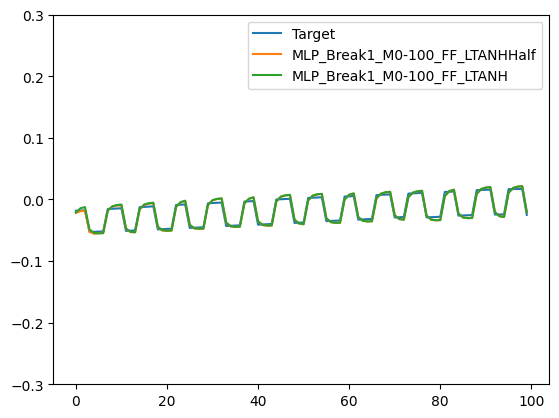

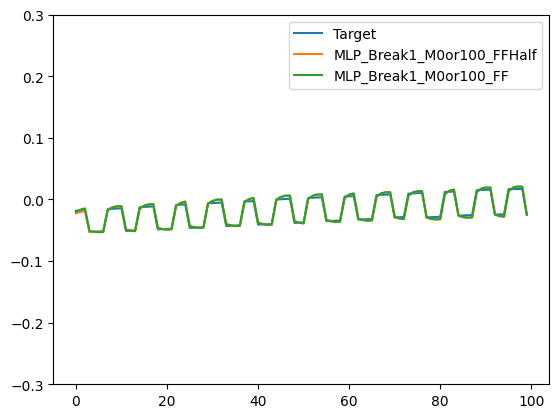

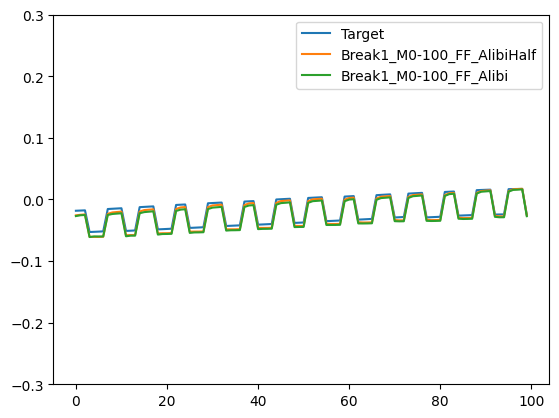

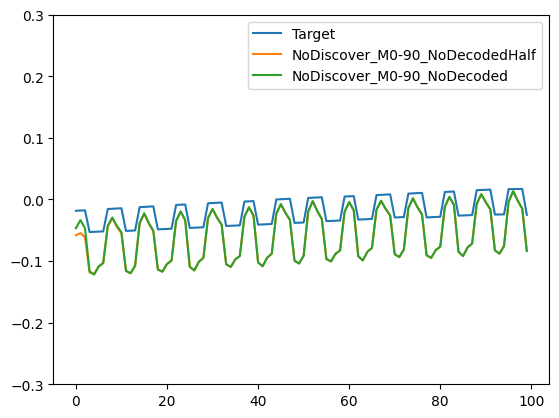

In [176]:
for name in logits:

    plt.plot(item["targets"]["state_decoded"][seq_to_plot,100:,0], label="Target")

    plt.plot(logits_half[name]["state_decoded"][seq_to_plot,:,0], label=name+"Half")

    plt.plot(logits[name]["state_decoded"][seq_to_plot,100:,0], label=name)

    plt.ylim(-0.3, 0.3)

    plt.legend()

    plt.show()


In [160]:
sensorial_masks_half_masked = TensorDict(
                        device=device, batch_size=batch_size)

sensorial_data: TensorDict = inputs
for name in sensorial_data.keys():
    sensorial_masks_half_masked[name] = torch.zeros(
        (batch_size, 100), dtype=bool, device=device)

In [161]:
state_half_masked = {name:state[name][:, 100:].clone() for name in state}

inputs_half_masked = {}

for name in inputs.keys():
    inputs_half_masked[name] = inputs[name][:, 100:].clone()

inputs_half_masked = TensorDict(inputs_half_masked)

for i in range(100):
    logits_half_masked = {}
    for name in models:
        if name == "NoDiscover_M0-90":
            state_decoded = inputs["state_decoded"]
        else:
            state_decoded = None


        logits_half_masked[name] = models[name](
            state=state_half_masked[name],
            state_decoded=state_decoded,
            sensorial_data=inputs_half_masked, sensorial_masks=sensorial_masks_half_masked, input_sequence_size=100)

        if i != 100-1:
            state_half_masked[name][:, i+1] = logits_half_masked[name]["state"][:, i]

logits_half_masked = {name:logits_half_masked[name].cpu() for name in logits_half_masked}

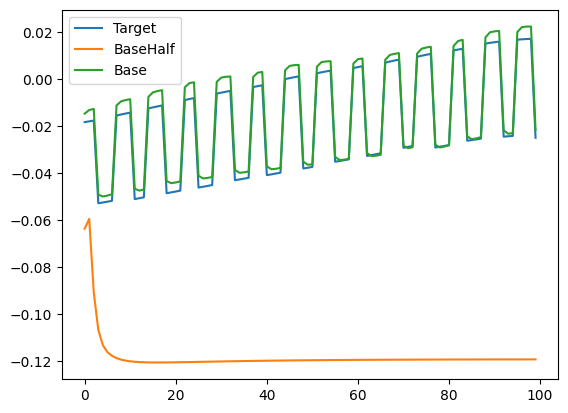

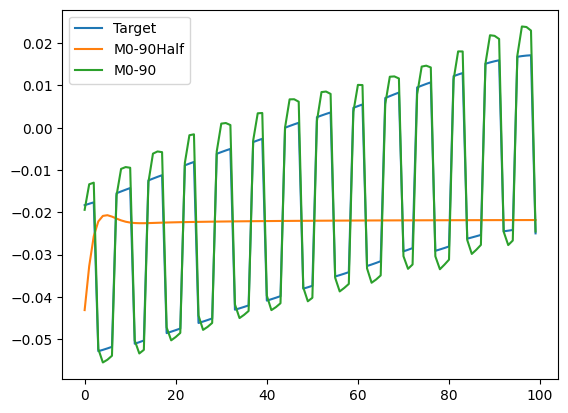

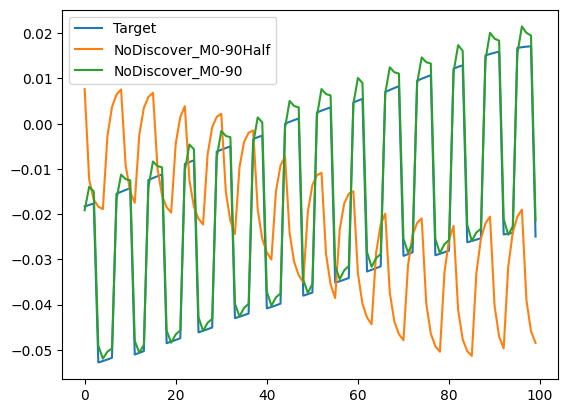

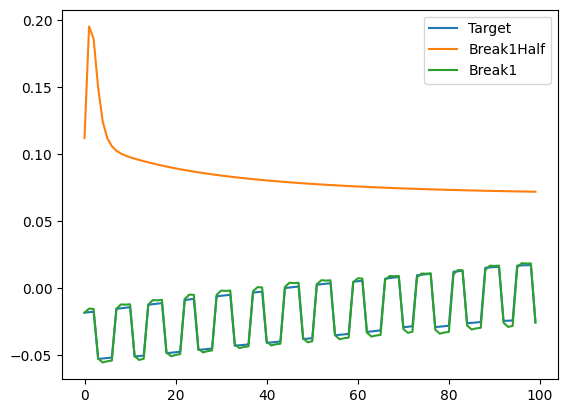

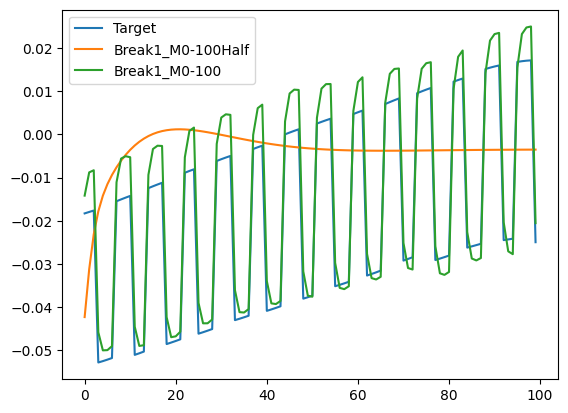

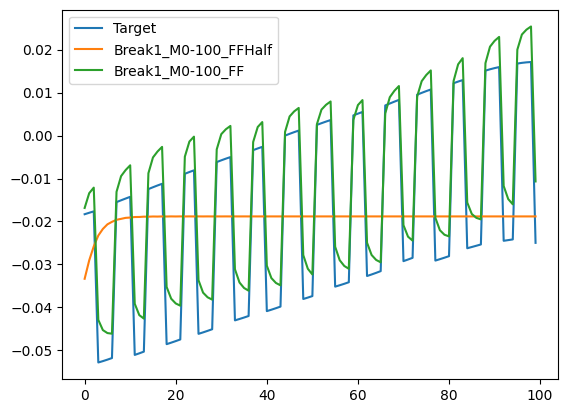

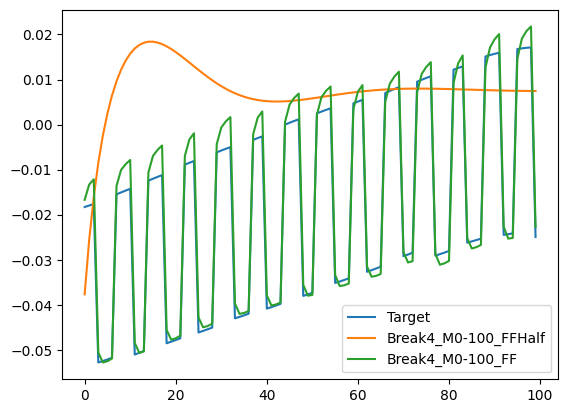

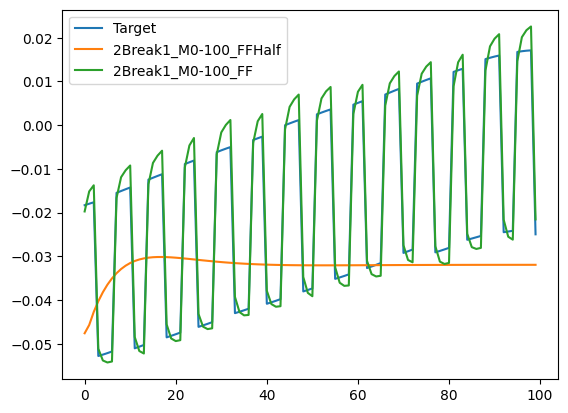

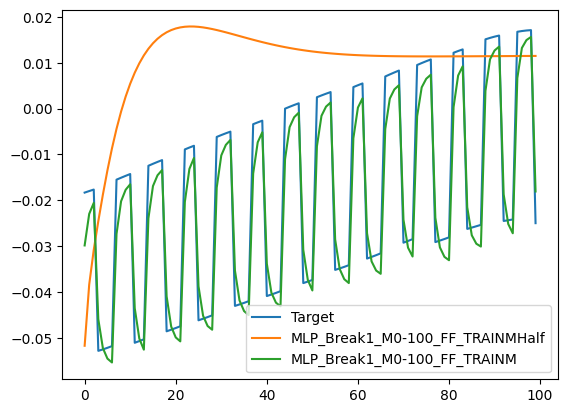

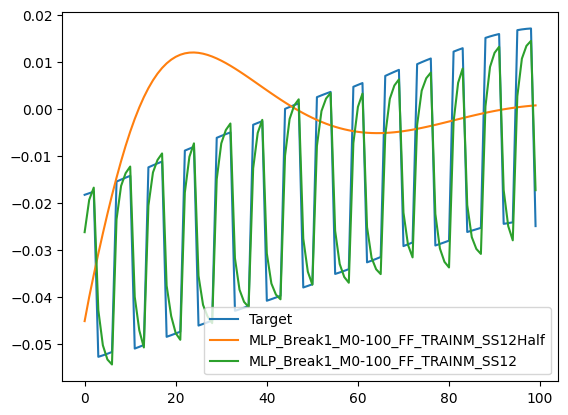

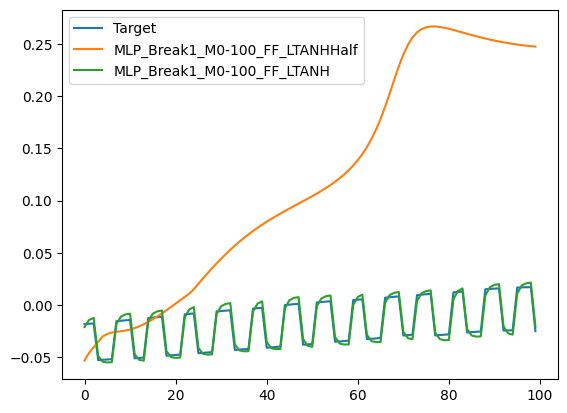

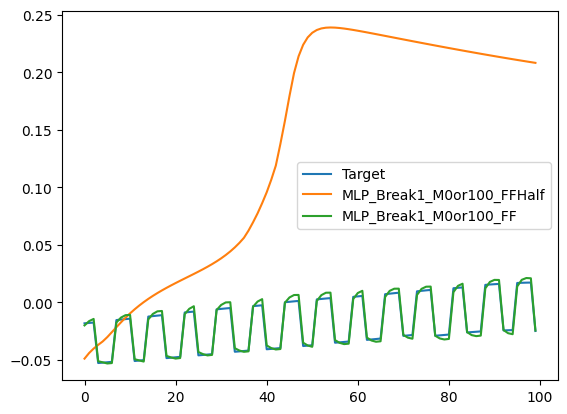

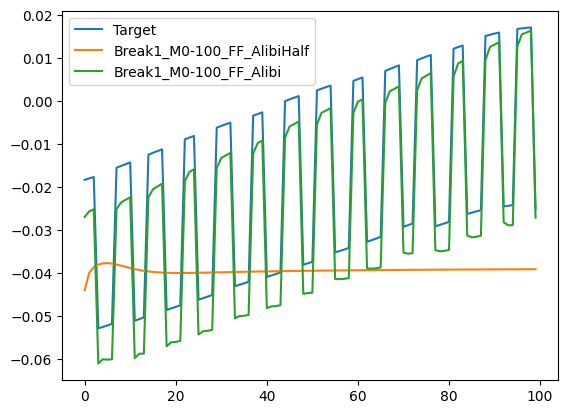

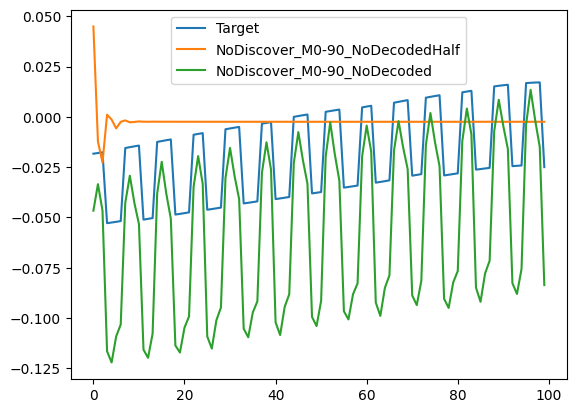

In [177]:
for name in logits:

    plt.plot(item["targets"]["state_decoded"][seq_to_plot,100:,0], label="Target")

    plt.plot(logits_half_masked[name]["state_decoded"][seq_to_plot,:,0], label=name+"Half")

    plt.plot(logits[name]["state_decoded"][seq_to_plot,100:,0], label=name)

    plt.legend()
    #plt.ylim(-0.3, 0.3)

    plt.show()


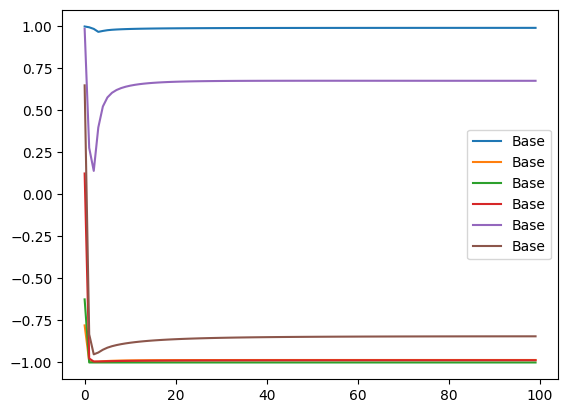

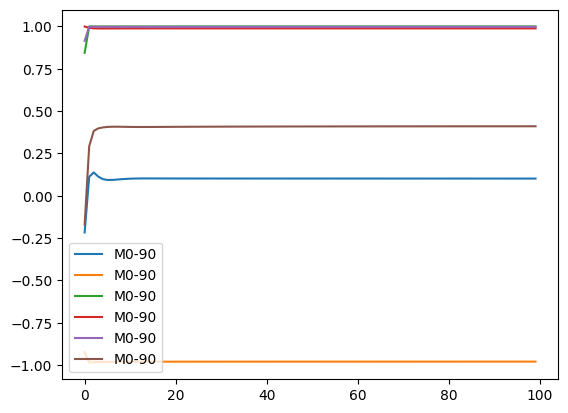

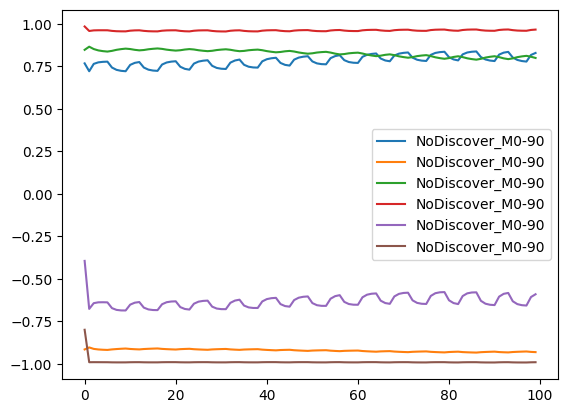

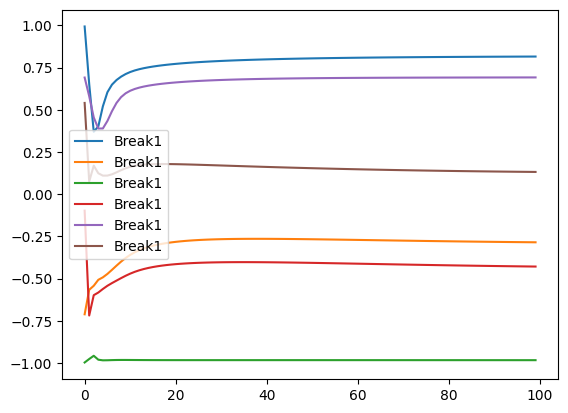

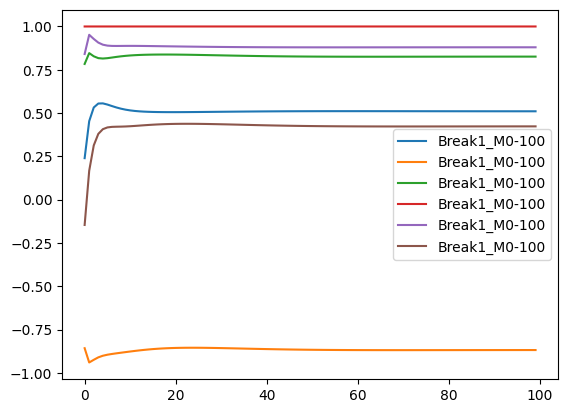

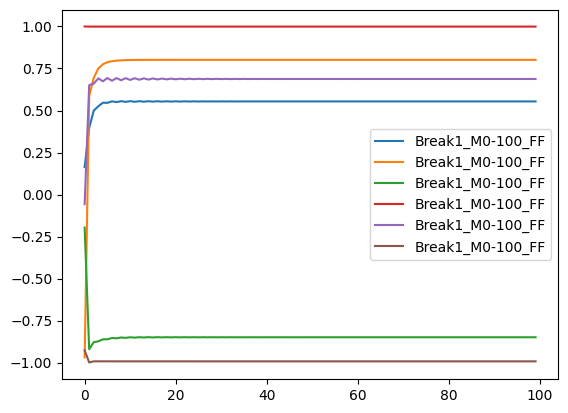

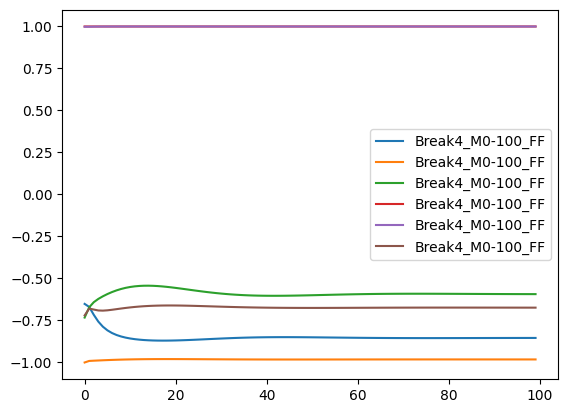

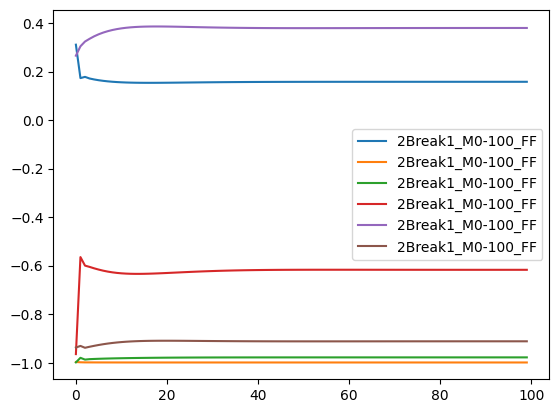

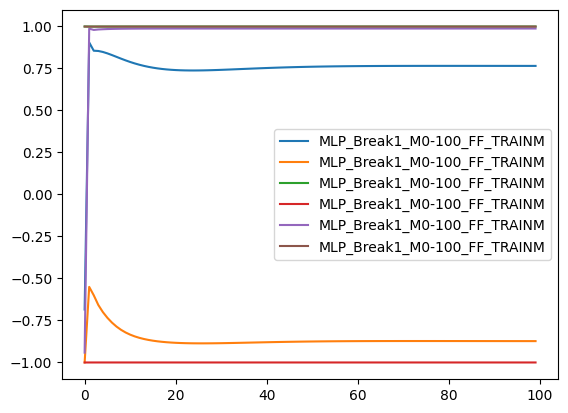

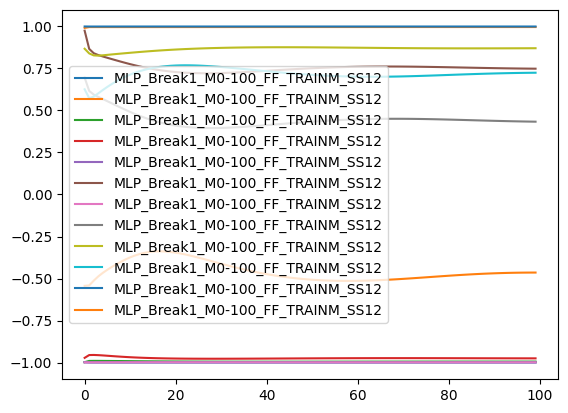

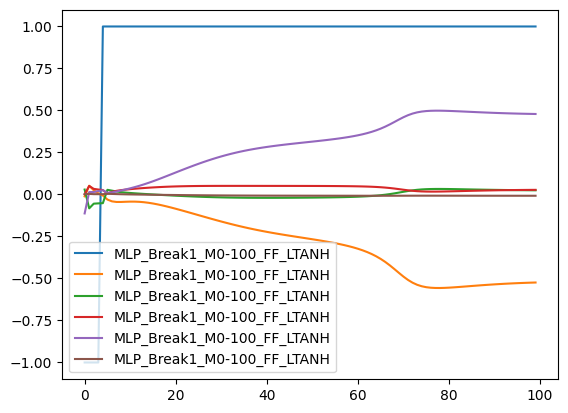

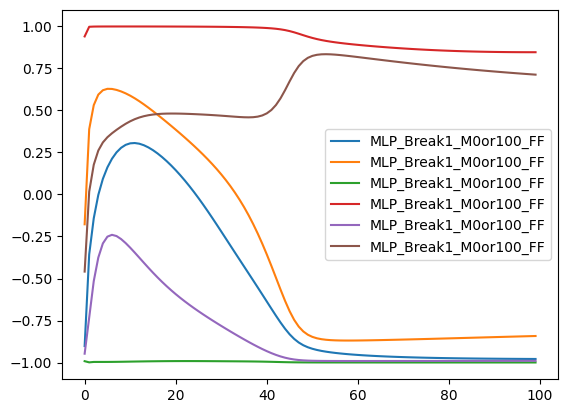

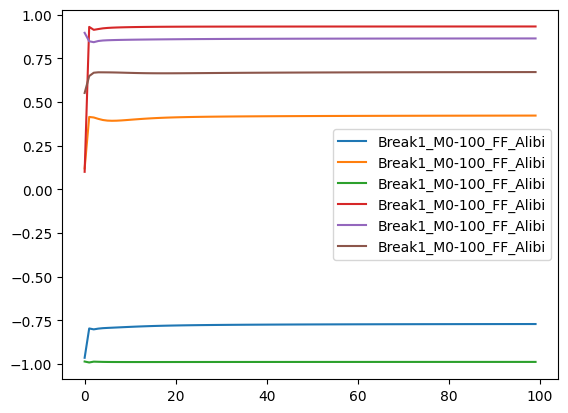

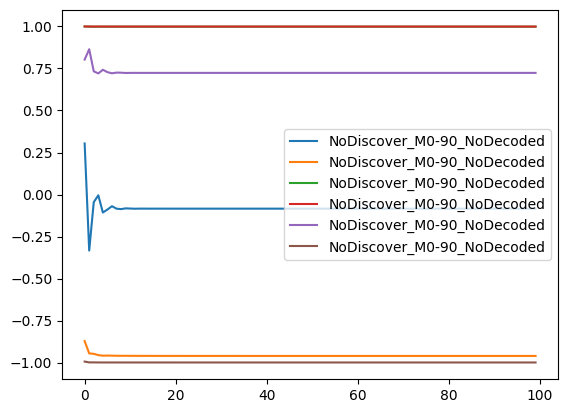

In [178]:
for name in logits:

    plt.plot(state_half_masked[name][seq_to_plot].cpu(), label=name)

    plt.legend()

    plt.show()


In [164]:
sensorial_masks_masked = TensorDict(
                        device=device, batch_size=batch_size)

sensorial_data: TensorDict = inputs
for name in sensorial_data.keys():
    sensorial_masks_masked[name] = torch.zeros(
        (batch_size, seq_len), dtype=bool, device=device)

In [165]:
state_masked = {name:state[name].clone() for name in state}

for i in range(100, seq_len):
    logits_masked = {}
    for name in models:
        if name == "NoDiscover_M0-90":
            state_decoded = inputs["state_decoded"]
        else:
            state_decoded = None


        logits_masked[name] = models[name](
            state=state_masked[name],
            state_decoded=state_decoded,
            sensorial_data=inputs, sensorial_masks=sensorial_masks_masked)

        if i != seq_len-1:
            state_masked[name][:, i+1] = logits_masked[name]["state"][:, i]

logits_masked = {name:logits_masked[name].cpu() for name in logits_masked}

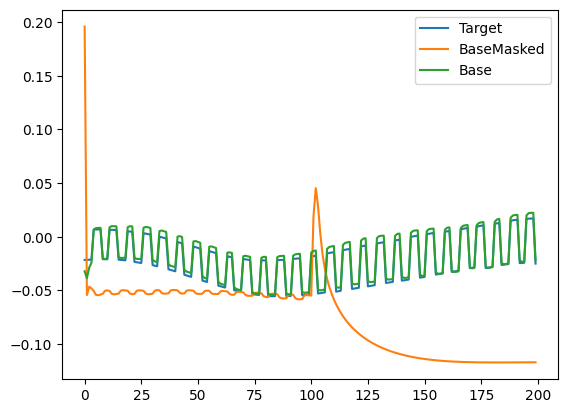

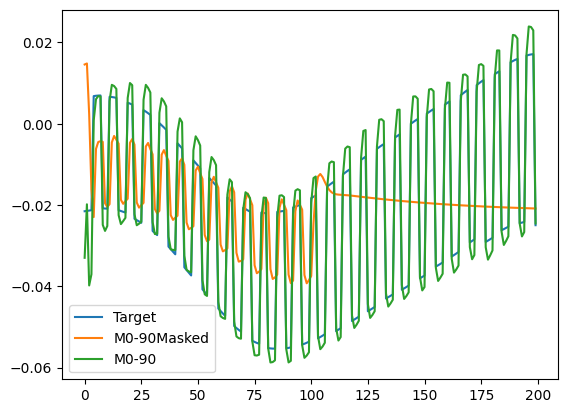

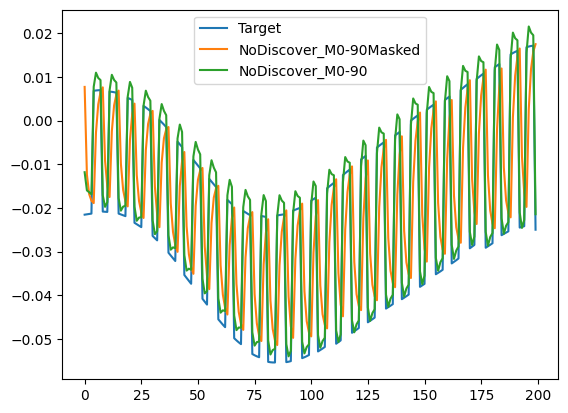

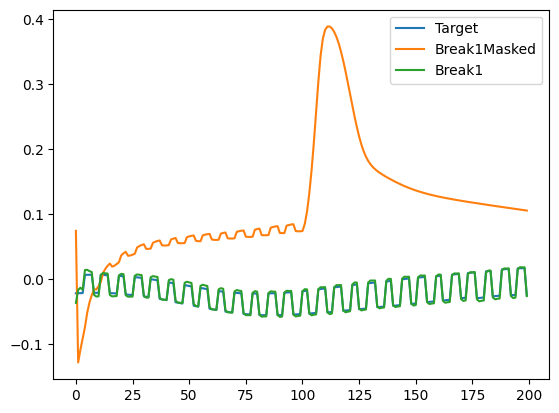

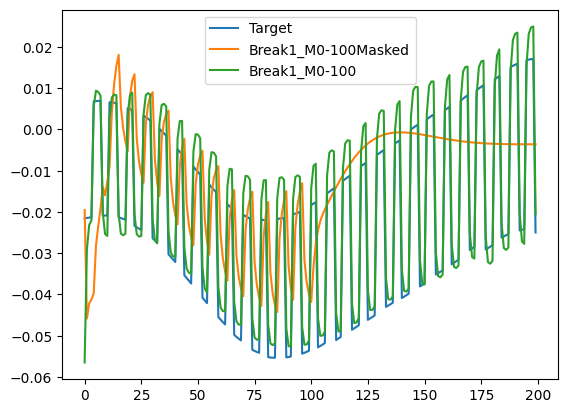

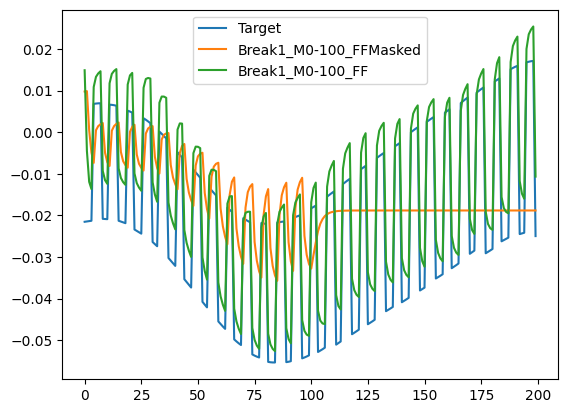

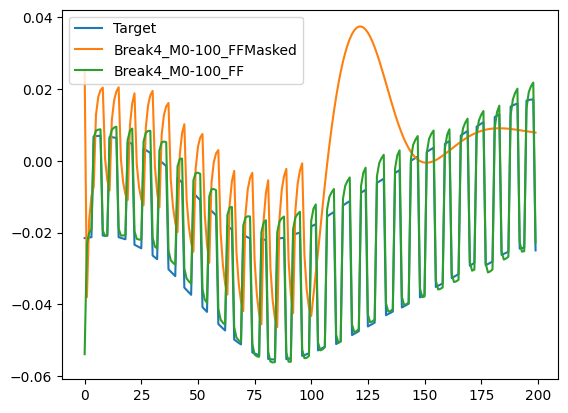

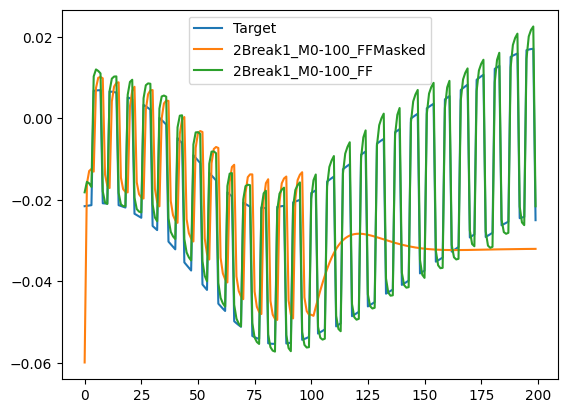

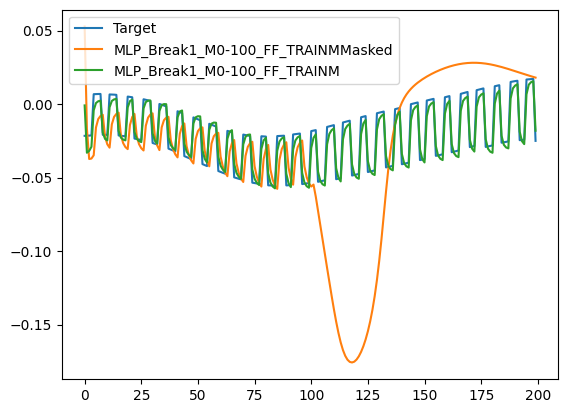

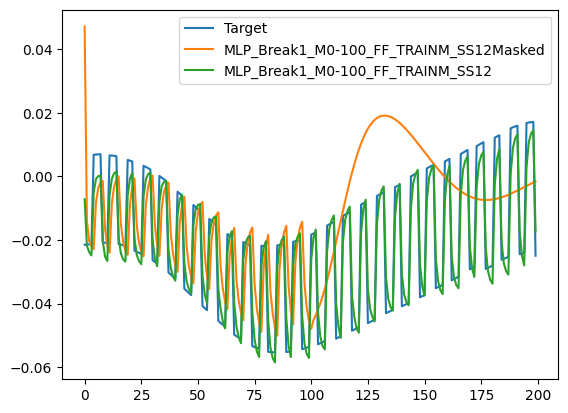

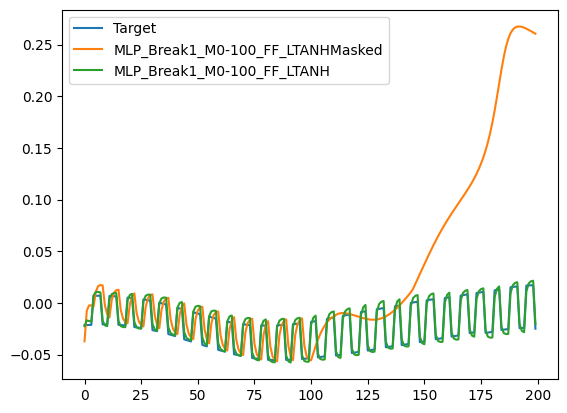

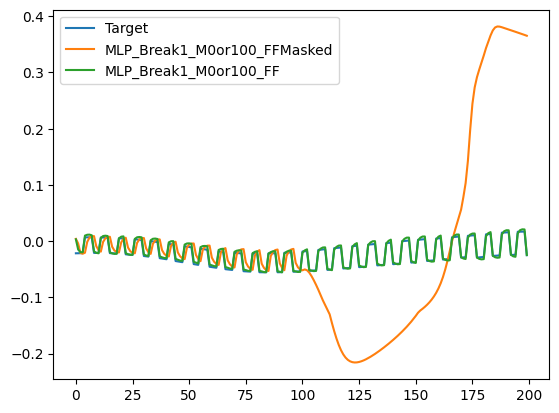

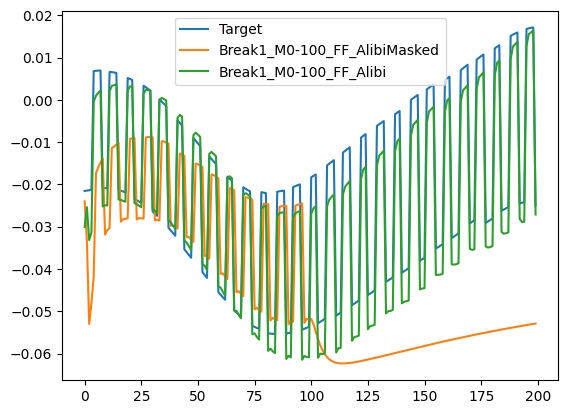

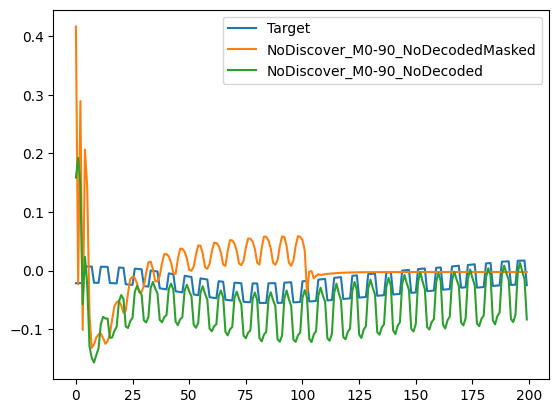

In [179]:
for name in logits:

    plt.plot(item["targets"]["state_decoded"][seq_to_plot,:,0], label="Target")

    plt.plot(logits_masked[name]["state_decoded"][seq_to_plot,:,0], label=name+"Masked")

    plt.plot(logits[name]["state_decoded"][seq_to_plot,:,0], label=name)

    plt.legend()
    #plt.ylim(-0.3, 0.3)

    plt.show()


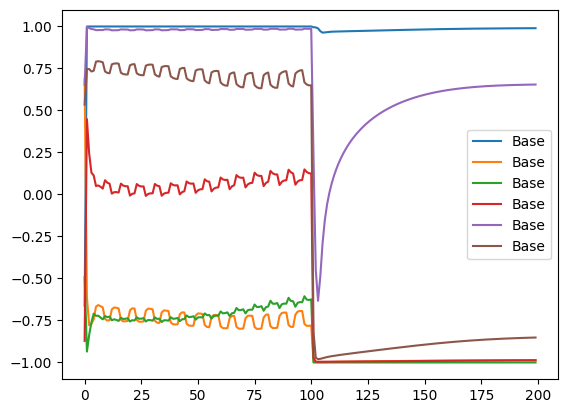

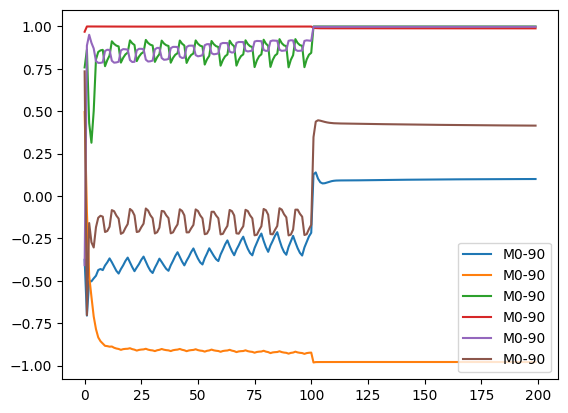

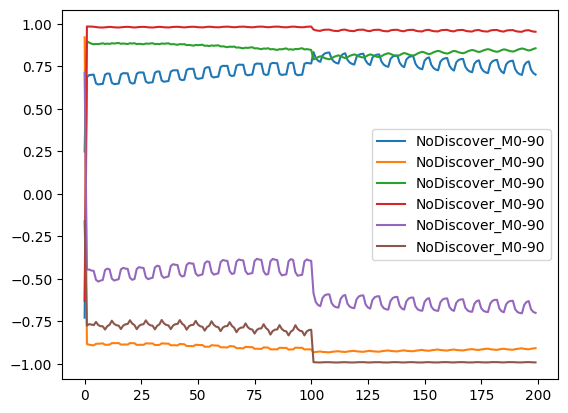

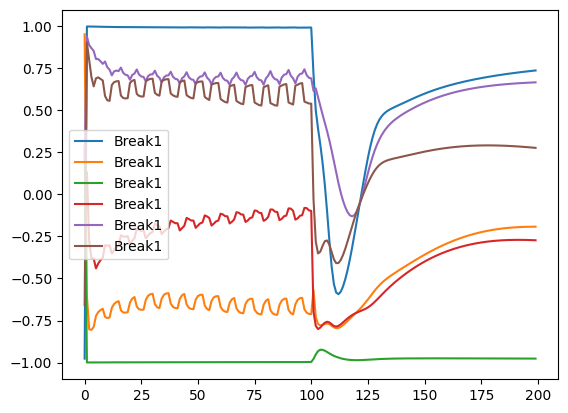

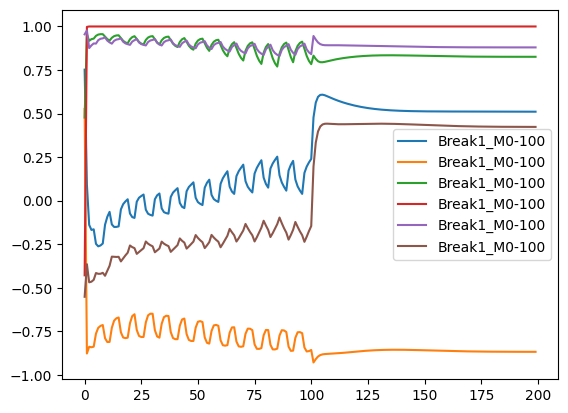

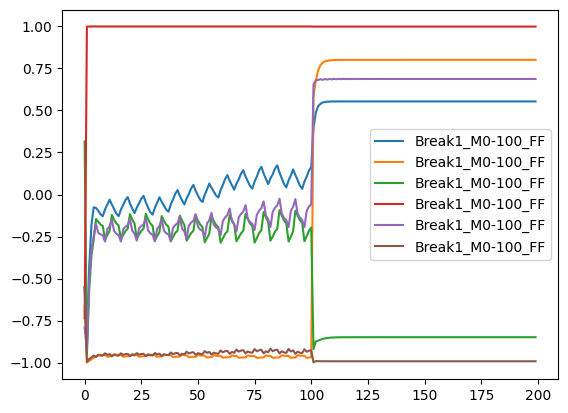

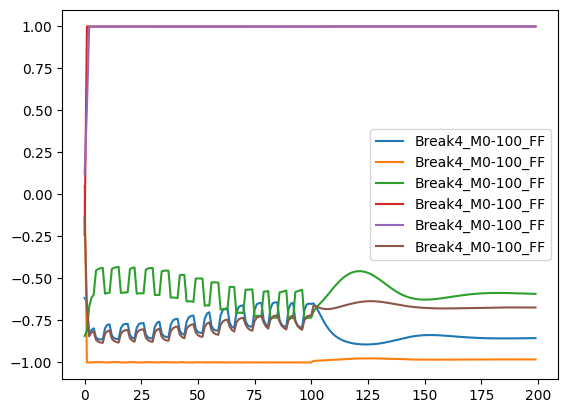

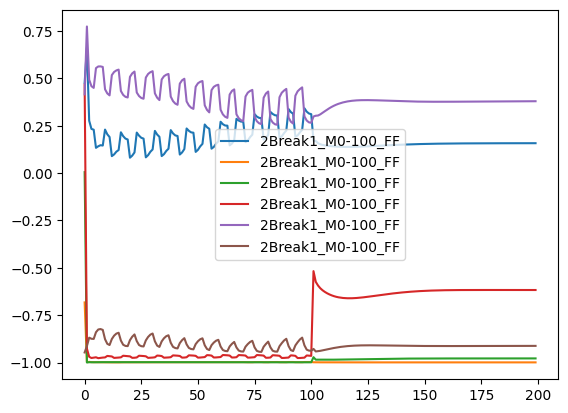

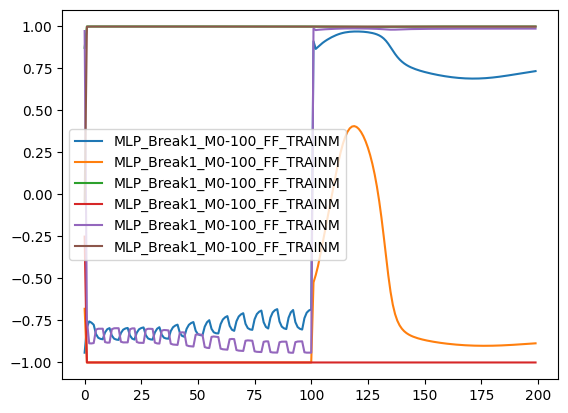

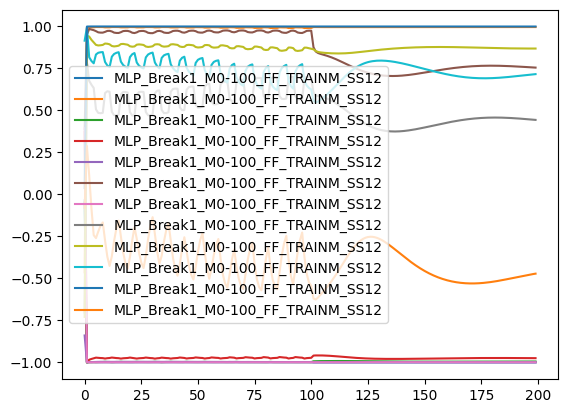

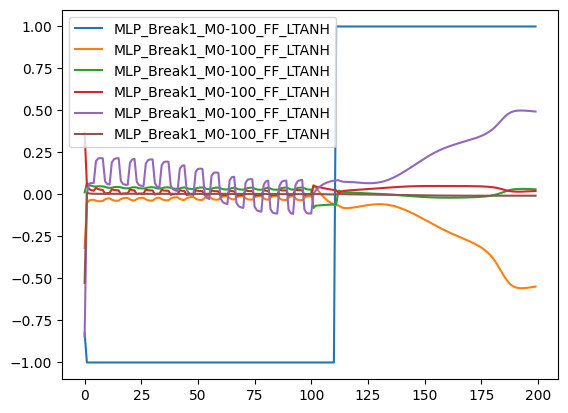

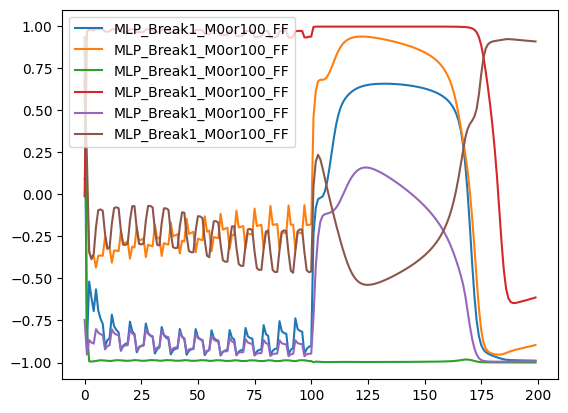

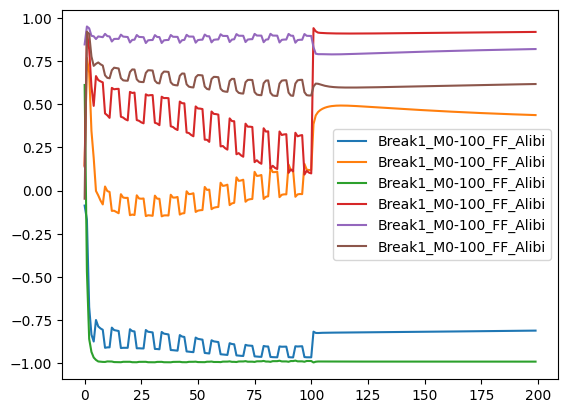

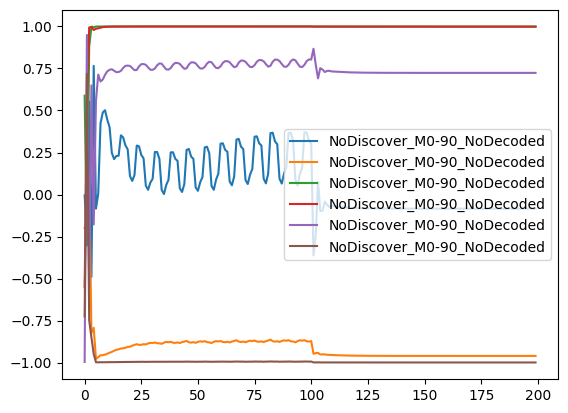

In [180]:
for name in logits:

    plt.plot(state_masked[name][seq_to_plot].cpu(), label=name)

    plt.legend()

    plt.show()


In [168]:
for name in models:
    print(name, end="| ")
    for i in range(2):
        print(models[name]._blocks[0].block.attention.attention._positional_encoder._m.cpu().item(), end="| ")
    print()

Base| 0.04114929586648941| 0.04114929586648941| 
M0-90| 0.0293508842587471| 0.0293508842587471| 
NoDiscover_M0-90| 0.8705938458442688| 0.8705938458442688| 
Break1| 0.017620012164115906| 0.017620012164115906| 
Break1_M0-100| 0.39587095379829407| 0.39587095379829407| 
Break1_M0-100_FF| 99775080.0| 99775080.0| 
Break4_M0-100_FF| 0.05976605787873268| 0.05976605787873268| 
2Break1_M0-100_FF| 0.04962514713406563| 0.04962514713406563| 
MLP_Break1_M0-100_FF_TRAINM| 0.03710060194134712| 0.03710060194134712| 
MLP_Break1_M0-100_FF_TRAINM_SS12| 0.04590991511940956| 0.04590991511940956| 
MLP_Break1_M0-100_FF_LTANH| 0.06594515591859818| 0.06594515591859818| 
MLP_Break1_M0or100_FF| 0.8033221960067749| 0.8033221960067749| 
Break1_M0-100_FF_Alibi| 0.00390625| 0.00390625| 
NoDiscover_M0-90_NoDecoded| 0.8705938458442688| 0.8705938458442688| 


Name|m0|m1
-|-|-
Base| 0.023069575428962708| 0.023069575428962708| 
M0-90| 0.027756547555327415| 0.027756547555327415| 
NoDiscover_M0-90| 0.6686981916427612| 0.6686981916427612| 
Break1| 0.06898923963308334| 0.06898923963308334| 
Break1_M0-100| 0.0382746160030365| 0.0382746160030365| 
Break4_M0-100_FF| -1.666601379914842e+18| -1.666601379914842e+18| 
2Break1_M0-100_FF| 0.020985325798392296| 0.020985325798392296| 
MLP_Break1_M0-100_FF_TRAINM| 2.279055118560791| 2.279055118560791| 
MLP_Break1_M0-100_FF_TRAINM_SS12| 0.12778246402740479| 0.12778246402740479| 
MLP_Break1_M0-100_FF_LTANH| 2.250190496444702| 2.250190496444702| 
MLP_Break1_M0or100_FF| 0.020191647112369537| 0.020191647112369537| 
NoDiscover_M0-90_NoDecoded| 0.6686981916427612| 0.6686981916427612| 

In [169]:
torch.finfo(torch.float32)

finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=float32)